In [1]:
import pandas as pd
import numpy as np
import json
import os
from helper import load_data, load_data_im2recipe
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
import requests
from food_extractor.food_model import FoodModel
import seaborn as sns
import pickle

%load_ext autoreload
%autoreload 2

# - Load the data

## Yummly data

In [4]:
df_yummly = load_data(cache=False, lists_folder='../foodprint/data/lists/', recipes_folder='../foodprint/data/recipes/')
df_yummly.head()

id  \
0  Sake-and-Ginger-Soba-Noodle-Salmon-Stir-Fry_-2...   
1      Japanese-Teriyaki-Style-Glazed-Salmon-2036776   
2                             Salmon-teriyaki-308049   
3                     Honey-Teriyaki-Chicken-1038563   
4        Mirin-Glazed-Salmon-Once-Upon-A-Chef-200003   

                                     recipeName  \
0  Sake and Ginger Soba Noodle Salmon Stir Fry.   
1         Japanese Teriyaki-Style Glazed Salmon   
2                               Salmon Teriyaki   
3                        Honey Teriyaki Chicken   
4                           Mirin Glazed Salmon   

                                         ingredients  
0  [sake, low sodium soy sauce, fresh ginger, gar...  
1  [salmon fillets, sea salt, cracked black peppe...  
2   [salmon, soy sauce, mirin, sugar, vegetable oil]  
3  [boneless skinless chicken thighs, honey, teri...  
4  [mirin, light brown sugar, soy sauce, salmon f...

In [2]:
df_yummly=pd.DataFrame()

## im2recipe data

### From source file

In [146]:
df_im2recipe_all = load_data_im2recipe(recipes_folder='../foodprint/data/im2recipes/')
df_im2recipe_all.head()

id                                       recipeName  \
0  000095fc1d                                  Yogurt Parfaits   
1  00051d5b9d  Salt Free, Low Cholesterol Sugar Cookies Recipe   
2  00059b093b                     Honey Sriracha Chicken Wings   
3  0005fc89f7                           Shrimp and Caper Salad   
4  0006ca31f4         Natural Peanut Butter Chocolate Bon Bons   

                                         ingredients  
0  [yogurt greek plain nonfat, strawberries raw, ...  
1  [sugars granulated, oil corn peanut and olive,...  
2  [chicken broilers or fryers wing meat and skin...  
3  [crustaceans shrimp raw (not previously frozen...  
4  [cocoa dry powder unsweetened, honey, peanut b...

In [150]:
df_im2recipe = df_im2recipe_all.copy()

### From cache file

In [6]:
df_im2recipe = pickle.load(open('../foodprint/cached_data/cached_im2recipe.pickle','rb'))

In [7]:
df_im2recipe.shape

(51235, 5)

## Concat Yummly & im2recipe

In [8]:
df = pd.concat([df_yummly, df_im2recipe]).reset_index(drop=True)
print(df_yummly.shape)
print(df_im2recipe.shape)
print(df.shape)

(0, 0)
(51235, 5)
(51235, 5)


### ADD CO2

#### Random CO2

In [153]:
df.head()

id                                       recipeName  \
0  000095fc1d                                  Yogurt Parfaits   
1  00051d5b9d  Salt Free, Low Cholesterol Sugar Cookies Recipe   
2  00059b093b                     Honey Sriracha Chicken Wings   
3  0005fc89f7                           Shrimp and Caper Salad   
4  0006ca31f4         Natural Peanut Butter Chocolate Bon Bons   

                                         ingredients  
0  [yogurt greek plain nonfat, strawberries raw, ...  
1  [sugars granulated, oil corn peanut and olive,...  
2  [chicken broilers or fryers wing meat and skin...  
3  [crustaceans shrimp raw (not previously frozen...  
4  [cocoa dry powder unsweetened, honey, peanut b...

In [154]:
df_co2 = pd.read_csv('../foodprint/data/dishes_with_co2.csv')
print(df_co2.shape)
df_co2.head()

(51235, 11)


id                                        dish_name  \
0  000095fc1d                                  Yogurt Parfaits   
1  00051d5b9d  Salt Free, Low Cholesterol Sugar Cookies Recipe   
2  00059b093b                     Honey Sriracha Chicken Wings   
3  0005fc89f7                           Shrimp and Caper Salad   
4  0006ca31f4         Natural Peanut Butter Chocolate Bon Bons   

                                         ingredients  \
0  ['yogurt, greek, plain, nonfat', 'strawberries...   
1  ['sugars, granulated', 'oil, corn, peanut, and...   
2  ['chicken, broilers or fryers, wing, meat and ...   
3  ['crustaceans, shrimp, raw (not previously fro...   
4  ['cocoa, dry powder, unsweetened', 'honey', 'p...   

                                     weight_per_ingr  total_dish_weight  \
0                             [226.796, 152.0, 30.5]         409.296000   
1  [100.80000000000001, 168.0, 21.25, 5.166666666...         747.808333   
2  [1360.7759999999998, 6.0, 1.15, 13.5, 42.59999...        1579.409333   
3  [907.184, 75.0, 151.5, 25.799999999999997, 134...        1574.431917   
4                            [1032.0, 4068.0, 256.0]        5356.000000   

   total_footprint  dish_footprint_per_100gr  confidence_score  \
0         0.522744                  0.127718          1.000000   
1         1.189488                  0.159063          1.000000   
2         6.446860                  0.408182          1.000000   
3         5.838564                  0.370836          0.983613   
4         4.367520                  0.081544          0.807319   

   dish_footprint_per_kilo co2_score  km_driven_per_100gr  
0                 1.277178       low             0.494907  
1                 1.590633       low             0.616370  
2                 4.081817      high             1.581704  
3                 3.708362      high             1.436990  
4                 0.815444       low             0.315985

In [155]:
df = df.merge(df_co2[['id','dish_footprint_per_100gr']], on='id', how='inner')

In [156]:
df.rename(columns={'dish_footprint_per_100gr':'co2'}, inplace=True)
df.head()

id                                       recipeName  \
0  000095fc1d                                  Yogurt Parfaits   
1  00051d5b9d  Salt Free, Low Cholesterol Sugar Cookies Recipe   
2  00059b093b                     Honey Sriracha Chicken Wings   
3  0005fc89f7                           Shrimp and Caper Salad   
4  0006ca31f4         Natural Peanut Butter Chocolate Bon Bons   

                                         ingredients       co2  
0  [yogurt greek plain nonfat, strawberries raw, ...  0.127718  
1  [sugars granulated, oil corn peanut and olive,...  0.159063  
2  [chicken broilers or fryers wing meat and skin...  0.408182  
3  [crustaceans shrimp raw (not previously frozen...  0.370836  
4  [cocoa dry powder unsweetened, honey, peanut b...  0.081544

# - Clean the ingredients

## FoodBert

In [33]:
model = FoodModel("chambliss/distilbert-for-food-extraction")

In [157]:
df_cleaned = df.copy()

In [158]:
df_cleaned['ingredients2'] = df_cleaned['ingredients'].apply(lambda x : \
                                                                     [ing['text'] for ing in model.extract_foods(','.join([ing for ing in x]))[0]['Ingredient']])


In [159]:
df_cleaned.drop(columns=['ingredients'], inplace=True)
df_cleaned.rename(columns={'ingredients2':'ingredients'}, inplace=True)
print(df_cleaned.shape)
df_cleaned.head(-10)

(51235, 4)


id                                       recipeName       co2  \
0      000095fc1d                                  Yogurt Parfaits  0.127718   
1      00051d5b9d  Salt Free, Low Cholesterol Sugar Cookies Recipe  0.159063   
2      00059b093b                     Honey Sriracha Chicken Wings  0.408182   
3      0005fc89f7                           Shrimp and Caper Salad  0.370836   
4      0006ca31f4         Natural Peanut Butter Chocolate Bon Bons  0.081544   
...           ...                                              ...       ...   
51220  ffefad6dcc                           Pumpkin-raisin Cookies  0.204514   
51221  fff06938d1          Mother's Sticky Roasted Chicken (Cajun)  0.318114   
51222  fff1025216                     Country Dijon Salad Dressing  0.182401   
51223  fff2c7c05d                            Zesty Mashed Potatoes  0.181304   
51224  fff5be8363                               Southwest Smoothie  0.068261   

                                             ingredients  
0        [yogurt, greek, strawberries, cereals, granola]  
1      [sugar, oil corn peanut, olive, egg substitute...  
2      [chicken, broil, meat, skin, salt table, spice...  
3      [crust, aceans shrimp, onions spring, scallion...  
4         [cocoa dry powder, honey, peanut butter, salt]  
...                                                  ...  
51220  [wheat flour, sugars, powder, sodium aluminum ...  
51221  [salt, spices paprika, spices pepper red, caye...  
51222  [yellow, apple juice, sugars, parsley, spices ...  
51223  [skin, soymilk, vanilla, horseradish, oil canola]  
51224  [banana, papayas, milk fluid, vitamin a, vitam...  

[51225 rows x 4 columns]

In [160]:
df = df_cleaned.copy()

In [161]:
df.head()

id                                       recipeName       co2  \
0  000095fc1d                                  Yogurt Parfaits  0.127718   
1  00051d5b9d  Salt Free, Low Cholesterol Sugar Cookies Recipe  0.159063   
2  00059b093b                     Honey Sriracha Chicken Wings  0.408182   
3  0005fc89f7                           Shrimp and Caper Salad  0.370836   
4  0006ca31f4         Natural Peanut Butter Chocolate Bon Bons  0.081544   

                                         ingredients  
0    [yogurt, greek, strawberries, cereals, granola]  
1  [sugar, oil corn peanut, olive, egg substitute...  
2  [chicken, broil, meat, skin, salt table, spice...  
3  [crust, aceans shrimp, onions spring, scallion...  
4     [cocoa dry powder, honey, peanut butter, salt]

## Food Categorization

In [162]:
df_ingredients = df[['ingredients']]

In [163]:
df_ingredients.head()

ingredients
0    [yogurt, greek, strawberries, cereals, granola]
1  [sugar, oil corn peanut, olive, egg substitute...
2  [chicken, broil, meat, skin, salt table, spice...
3  [crust, aceans shrimp, onions spring, scallion...
4     [cocoa dry powder, honey, peanut butter, salt]

In [164]:
df_ingredients['bow'] = df_ingredients.ingredients.apply(convert_to_dict)
vect_test = DictVectorizer(sparse=False)
vect_test.fit(df_ingredients.bow.tolist())

/tmp/ipykernel_434/228694153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ingredients['bow'] = df_ingredients.ingredients.apply(convert_to_dict)


DictVectorizer(sparse=False)

In [165]:
ingredients = pd.DataFrame(vect_test.feature_names_)

In [166]:
ingredients.shape

(1390, 1)

# Pipeline

## - Convert ingredients into dict

In [9]:
def convert_to_dict(arr, recipeName):
    ''' Helper function to convect an array of ingredients to a dictionary '''
    d={}
    print(arr)
    for a in arr:
        d[a] = 1
    return d

In [16]:
df['name_and_ing'] = df['ingredients'].apply(lambda x : x.insert(0,'a'))
df['name_and_ing']

0        None
1        None
2        None
3        None
4        None
         ... 
51230    None
51231    None
51232    None
51233    None
51234    None
Name: name_and_ing, Length: 51235, dtype: object

In [10]:
# First we create a bag of words per recipe
df['bow'] = df.ingredients.apply(convert_to_dict, args=())

['yogurt', 'greek', 'strawberries', 'cereals', 'granola']
['sugar', 'oil corn peanut', 'olive', 'egg substitute powder', 'orange juice', 'orange juice', 'powder', 'sodium aluminum sulfate', 'wheat flour']
['chicken', 'broil', 'meat', 'skin', 'salt table', 'spices pepper black', 'oil olive salad', 'butter', 'salt', 'sauce hot chile sriracha', 'honey', 'rice white', 'salt', 'soy sauce', 'tamari', 'sauce hoisin', 'salt table', 'spices coriander seed']
['crust', 'aceans shrimp', 'onions spring', 'scallions', 'tops', 'bulb', 'celery', 'capers', 'olives', 'oil olive salad', 'salad dressing mayonnaise', 'celery', 'lemon juice']
['cocoa dry powder', 'honey', 'peanut butter', 'salt']
['cheese', 'paste', 'american', 'vitamin d', 'milk fluid', 'vitamin a', 'vitamin', 'salt table', 'spices pepper red', 'cayenne']
['chocolate baking chips', 'cheese parmesan', 'milk buttermilk fluid', 'lowfat', 'sugars', 'salt table']
['corn', 'yellow', 'wheat flour', 'seeds pumpkin', 'squash seeds', 'salt', 'salt t

['butter', 'salt', 'cream fluid', 'syrups corn', 'sugars']
['sugar', 's brown', 'spices chili powder', 'spices paprika', 'spices cumin seed', 'spices pepper red', 'cayenne', 'spices garlic powder', 'mustard', 'yellow', 'salt table', 'salt table', 'spices pepper black']
['popcorn', 'seeds sunflower seed kernels', 'seeds pumpkin', 'squash seeds', 'salt', 'butter', 'salt', 'honey', 'orange juice', 'spices nutmeg']
['wheat flour', 'wheat flour', 'sugars', 'salt', 'leave', 'baking soda', 'milk buttermilk', 'lowfa']
['cheese', 'parmesan', 'butter', 'salt', 'sugars', 'sugars', 'vanilla extract', 'chocolate baking']
['butter', 'salt', 'cocoa dry powder', 'sugars', 'milk fluid', 'vitamin a', 'vitamin d', 'vanilla extract']
['butter', 'salt', 'syrup maple canadian', 'vanilla extract', 'wheat flour white', 'soda', 'salt table', 'quinoa', 'oats', 'nuts pecans']
['cream fluid', 'honey', 'alcoholic', 'whiskey', 'raspberries']
['wheat flour', 'baking soda', 'powder', 'sodium aluminum sulfate', 'salt 

['oats', 'yogurt greek', 'orange juice', 'sugars', 'apples', 'bananas', 'blueberries']
['wheat flour', 'sugars', 'baking soda', 'salt table', 'margarine', 'fat composite stick', 'salt', 'milk buttermilk', 'cranberries', 'chocolate baking chips', 'spices cinnamon ground', 'cream whipped cream topping', 'sugars', 'spices cinnamon ground']
['wheat flour', 'sugars', 'beverage beer', 'butter', 'salt']
['sugars', 'wheat flour', 'sugars', 'milk fluid', 'vitamin a', 'vitamin d', 'powder', 'sodium aluminum sulfate', 'peanut butter', 'salt']
['wheat flour', 'confectionery coconut', 'palm kernel', 'butter', 'salt', 'sugars', 'milk fluid', 'vitamin a', 'vitamin d']
['margarine', 'margarine', 'butter', 'soybean oil', 'butter', 'vinegar', 'tomatoes', 'red ripe', 'soy sauce', 'tamari', 'salt table', 'spices ginger ground', 'celery', 'onions']
['cranberries', 'sugars', 'spices ginger ground', 'shallots', 'molasses']
['ascha', 'bitter', 'dark chocolate chips', 'cream fluid', 'butter', 'salt', 'alcoholi

['butter', 'salt', 'blueberries', 'orange juice', 'sugars', 'vanilla extract', 'wheat flour white', 'powder', 'sodium aluminum sulfate', 'salt table', 'sugars', 'butter', 'salt', 'orange juice']
['milk', 'fluid', 'vitamin a', 'vitamin', 'cocoa dry powder', 'sweetener syrup', 'agave']
['chocolate baking chips', 'terra dolce organic chipotle', 'dried chile peppers', 'salt table', 'cream fluid', 'cocoa dry powder']
['nuts', 'almonds', 'seeds flaxseed', 'salt table', 'sweetener syrup agave', 'vanilla extract', 'confectionery coconut', 'palm kernel', 'water', 'blueberries', 'nuts cashew nuts', 'blackberries', 'lemon juice', 'sweetener syrup', 'water']
['butter', 'salt', 'sugars', 'syrup', 'corn', 'popcorn']
['water', 'chocolate baking chips', 'cream whipped cream topping']
['cats', 'salad dressing mayonnaise', 'pickle relish', 'sauce worcestershire', 'spices onion powder']
['olive salad', 'vinegar cider', 'sugars', 'ulated', 'catsup', 'salt table', 'spices paprika']
['butter', 'salt', 'suga

['butter', 'salt', 'oil canola', 'oil olive salad', 'milk fluid', 'vitamin a', 'vitamin', 'water', 'seeds flaxseed']
['cheese', 'parmesan', 'cheese blue', 'onions', 'parsley', 'nuts almonds']
['cream whipped cream topping', 'sugars', 'cocoa dry powder', 'chocolate baking chips']
['beans', 'green']
['pumpkin pie spice', 'sugars', 'spices cinnamon ground', 'apples', 'skin', 'honey', 'vanilla extract']
['potato', 'spices ginger ground', 'syrup maple canadian', 'spices cinnamon ground', 'margarine', 'fat composite stick', 'salt', 'nuts pecans', 'apples', 'skin']
['nuts', 'almonds', 'oil olive salad', 'crustaceans shrimp', 'shallots', 'marmalade orange', 'soy sauce', 'tamari', 'spices pepper black']
['cheese', 'parmesan', 'onions', 'mustard', 'yellow', 'spices basil', 'parsley', 'oil corn peanut', 'olive', 'lemon juice', 'spices pepper black']
['margarine', 'salt', 'spices garlic powder', 'salt table']
['apple juice', 'ascorbic acid', 'soda']
['sugar', "yeast baker'", 'oil olive salad', 'wh

['yellow', 'sauce', 'orcestershire']
['horseradish', 'salad dressing', 'mayonnaise', 'mustard', 'yellow', 'catsup', 'spices pepper black']
['cashew nuts', 'seeds pumpkin', 'squash seeds', 'salt', 'nuts walnuts', 'seeds sunflower seed kernels', 'seeds pumpkin', 'squash seeds', 'salt', 'raisins seeded', 'salt table', 'spices cinnamon ground', 'honey', 'confectionery coconut', 'palm kernel']
['spices', 'fennel seed', 'spices coriander seed', 'corn sweet white raw', 'salt table']
['sugar', 'milk fluid', 'vitamin a', 'vitamin d', 'syrups', 'corn light', 'butter', 'salt', 'peanut butter smooth', 'salt']
['sugar', 'oil olive salad', 'vinegar cider', 'mustard', 'yellow', 'sauce hot chile sriracha', 'salt table', 'spices ginger ground', 'celery raw', 'spices pepper black']
['beans', 'green', 'butter', 'salt', 'soy sauce', 'tamari', 'seeds sesame seeds']
['pickles cucumber sour', 'spices garlic powder', 'dill weed', 'mustard', 'yellow', 'cream sour']
['sugar', 'milk fluid', 'vitamin a', 'vitamin

['oil olive salad', 'honey', 'molasses', 'salt table', 'wheat flour', 'baker']
['wheat flour', 'sugars', 'butter', 'salt', 'nuts pecans', 'butter', 'salt', 'sugars', 'chocolate baking']
['alcoholic', 'vodka', 'orange juice', 'cranberries', 'lemon juice', 'sugars']
['wheat flours', 'bread', 'wheat flour', 'baker', 'salt']
['sugar', 'molasses', 'water', 'spices ginger ground', 'spices cinnamon ground', 'spices cloves', 'butter', 'salt', 'wheat flour', 'baking soda', 'salt table']
['butter', 'salt', 'sugars', 'milk fluid', 'vitamin a', 'vitamin d', 'chocolate baking chips']
['paragus', 'butter', 'salt', 'lemon juice', 'salt table', 'spices pepper black']
['pork', 'loin', 'ribs', 'salt table', 'spices pepper black', 'butter', 'salt', 'butter', 'salt', 'spices garlic powder', 'soup beef broth', 'bouillon', 'sauce worcesters']
['broil', 'bone', 'meat', 'milk fluid', 'vitamin', 'vitamin', 'bread crumbs', 'grated plain', 'salt table', 'spices pepper black', 'oil olive salad', 'cooking']
['wate

['chocolate baking chips', 'cream whipped cream topping']
['pork', 'fresh loin tenderloin', 'salt table', 'spices pepper black']
['wheat flour', 'wheat flour', 'seeds flaxsee', 'salt table', 'leave', 'baking soda', 'milk buttermilk', 'lowfa']
['wheat flour white', 'milk buttermilk fluid', 'lowfat', 'salad dressing mayonnaise', 'regular']
['confectionery coconut', 'palm kernel', 'bitter', 'dark chocolate chips']
['strawberries', 'sweetener syrup', 'agave']
['vegetable', 'cream sour', 'salad dressing mayonnaise', 'lemon juice', 'spinach', 'water']
['yellow', 'spices garlic powder', 'spices paprika', 'spices pepper black', 'salt table', 'spices pepper red', 'cayenne', 'pork fresh loin country', 'ribs', 'sauce barbecue']
['ions', 'butter', 'salt', 'pumpkin raw', 'salt table', 'sugars', 'spices nutmeg ground', 'spices pepper black', 'soup chicken broth', 'bouillon', 'cream whipped cream topping']
['aspberries', 'sugars']
['salt', 'spices pepper black']
['butter', 'salt', 'sugars', 'confecti

['yellow', 'sugars', 'alcoholic beverage beer', 'tomato sauce', 'salt', 'sauce', 'pepper tabasco']
['skin', 'mollusks', 'callop']
['paragus', 'artichokes', 'french', 'erries', 'oil olive salad', 'vinegar cider', 'salt table', 'spices pepper black', 'syrups sugar', 'soy sauce', 'tamari']
['milk', 'vitamin', 'vitamin', 'sugars', 'spices saffron', 'semolina', 'butter', 'salt', 'spices cardamom', 'nuts cashew nuts']
['yogurt', 'greek', 'ice cream', 'vanilla']
['apples', 'skin', 'syrup maple canadian', 'spices cinnamon ground']
['wheat flour', 'sugars', 'salt', 'powder', 'sodium aluminum sulfate', 'spices cinnamon ground', 'butter', 'salt', 'syrup maple canadian', 'vanilla extract']
['nuts', 'hazelnuts', 'filberts', 'butter', 'salt', 'sugars', 'wheat flour']
['milk', 'vitamin', 'vitamin', 'cream whipped cream topping', 'salt', 'lemon juice']
['garlic powder', 'spices onion powder', 'spices paprika', 'spices chili powder', 'spices cumin seed', 'salt table', 'chicken broiler', 'fryers', 'meat

['molasses', 'sugars', 'yeast baker', 'butter', 'salt', 'cream sour', 'cocoa dry powder', 'wheat flour', 'wheat flour', 'salt', 'spices caraway seed', 'seeds flaxsee']
['honey', 'mustard', 'yellow', 'lemon juice', 'spices poppy seed', 'spices pepper black']
['soy sauce', 'tamari', 'catsup', 'pineapple juice', 'sugars', 'salt table', 'spices pepper black']
['chicken', 'meat', 'olive salad', 'spices pepper red', 'cayenne', 'onions', 'mushrooms', 'spinach', 'radishes', 'vinegar red wine', 'honey', 'spices oregano', 'salt table', 'spices pepper black', 'spices pepper red', 'cayenne']
['strawberries', 'cream sour', 'sugars brown']
['corn', 'white', 'cream fluid', 'salt table', 'sugars', 'cornstarch']
['wheat flour', 'powder', 'sodium aluminum sulfate', 'sugars', 'salt table', 'milk buttermilk', 'lowfat', 'tomato sauce', 'salt', 'spices oregano dried', 'cheese cheddar', 'spinach']
['pork', 'fresh loin tenderloin', 'oil olive salad', 'onions', 'tomatoes', 'red ripe', 'sauce fish', 'salt table

['sugar', 'melons cantaloupe']
['snack', 'popcorn', 'sugars', 'syrup', 'corn', 'water', 'vinegar', 'salt table', 'butter', 'salt', 'spices nutmeg ground', 'vanilla extract', 'nuts pecans']
['yogurt greek', 'peanut butter', 'salt', 'spices cinnamon ground', 'chocolate baking']
['pancakes', 'dry mix', 'buttermilk', 'water', 'butter', 'salt', 'chocolate baking chips', 'cream fluid', 'whipping', 'sherbet orange', 'raspberries']
['milk fluid', 'vitamin', 'vitamin']
['rice', 'salt', 'nuts hazelnuts', 'filberts', 'raisins', 'cocoa dry powder', 'oil canola']
['sugar', 'cream fluid', 'syrup maple canadian', 'butter', 'salt', 'vanilla extract', 'candies', 'semisweet chocolate', 'nuts walnuts', 'glish']
['wheat flours', 'bread', 'salt', 'sugars', 'milk fluid', 'vitamin', 'vitamin', 'butter', 'salt', 'water', 'yeast baker']
['cream sour culture', 'horseradish', 'lemon juice', 'sauce worcestershire', 'salt table', 'spices pepper black']
['chicken', 'meat', 'beans', 'green raw', 'tomatoes', 'red rip

['calcium sulfate', 'oil olive salad']
['turkey', 'cheese parmesan', 'spices onion powder', 'spices garlic powder', 'spices cloves', 'mustard', 'yellow', 'catsup']
['pork', 'fresh loin tenderloin', 'sugars', 'salt table', 'spices cumin seed', 'spices cardamom']
['beans', 'green raw', 'butter', 'salt', 'mustard', 'yellow', 'sugars', 'lemon juice', 'vinegar']
['chocolate baking chips', 'milk can', 'peanut butter', 'salt', 'orange juice']
['tamarinds', 'sugars']
['sugar', 'cornstarch', 'beets', 'vinegar cider', 'orange juice', 'beets', 'orange juice']
['rots', 'salt table', 'parsley', 'horseradish', 'salad dressing mayonnaise', 'carrots', 'butter', 'salt', 'cereals oats', 'water', 'salt']
['chicken', 'meat', 'pick', 'salad dressing mayonnaise', 'cream sour', 'parsley', 'mustard', 'yellow', 'lemon juice', 'salt table', 'spices pepper black']
['sugar', 'orange juice', 'orange juice', 'cream fluid', 'orange juice']
['snack', 'popcorn', 'sugars brown', 'butter', 'salt', 'syrups', 'corn light'

['pork', 'loin', 'spices pepper black', 'salt table', 'spices garlic powder', 'spices onion powder', 'spices basil']
['potatoes', 'raw skin', 'honey']
['beef', 'grass', 'ground', 'soup', 'chicken can', 'condensed', 'snacks', 'tortilla chips', 'sauce salsa', 'cheese cheddar']
['sugars', 'vinegar cider', 'spices ginger ground', 'salt table', 'onions', 'mustard', 'yellow', 'spices cinnamon ground', 'spices cloves', 'nuts almonds']
['wheat flour', 'salt table']
['wheat flour', 'mustard', 'yellow', 'spices paprika', 'powder', 'sodium aluminum sulfate', 'butter', 'salt', 'cheese cheddar', 'sauce worcestershire']
['spices', 'ginger ground', 'spices garlic powder', 'oil canola', 'rice vinegar', 'oil sesame salad', 'soy sauce', 'tamari', 'water', 'honey', 'spices pepper black']
['butter', 'salt', 'sugars', 'vanilla extract', 'wheat flour', 'nuts pecans', 'sugars']
['yogurt', 'greek', 'nonfat', 'cheese feta', 'spices coriander seed', 'dill weed', 'spices pepper black']
['cranberries', 'sugars', 

['wheat flour white', 'cream sour']
['apples', 'skin', 'lemon juice', 'honey']
['pineapple', 'syrup maple canadian']
['syrup', 'maple canadian', 'milk fluid', 'vitamin a', 'vitamin d', 'baking soda', 'wheat flour white', 'nuts walnuts', 'glish', 'cranberries', 'pumpkin']
['wheat flour', 'powder', 'sodium aluminum sulfate', 'salt table', 'sugars', 'peanut butter', 'salt', 'milk fluid', 'vitamin a', 'vitamin d']
['orange juice', 'couscous', 'raisins', 'honey', 'spices cinnamon']
['olive salad']
['oil olive salad', 'lemon juice', 'salt table', 'honey', 'oats', 'wheat germ crude', 'wheat flours bread', 'nuts pecans', 'baker']
['beef', 'grass', 'ground', 'pork sausage', 'patty', 'cheese parmesan', 'wheat flours bread']
['currants zante', 'sugars']
['cereal', 'oats', 'water', 'salt', 'pretzels', 'white chocolate', 'bananas', 'raisins']
['squash', 'summer zucchini', 'skin', 'lemon juice', 'sugars', 'spices cinnamon ground', 'pumpkin raw', 'wheat flour', 'butter', 'salt']
['sugar', 'cream flui

['butter', 'salt', 'wheat flour', 'sugars', 'butter', 'salt', 'erries sweet', 'milk fluid', 'vitamin a', 'vitamin', 'sugars']
['cheese', 'cottage cream', 'curd', 'milk fluid', 'vitamin a', 'vitamin d']
['wheat flour', 'tomatoes', 'parsley', 'milk buttermilk', 'salt table']
['cajun', 'cajun', 'wheat flour', 'alcoholic beverage beer', 'spices paprika', 'salt table', 'spices pepper black']
['sugar', 'syrup', 'corn']
['butter', 'salt', 'milk fluid', 'vitamin a', 'vitamin d', 'chocolate baking chips', 'vanilla extract', 'sugars']
['ions spring', 'scallions', 'tops', 'bulb', 'oil corn peanut', 'olive', 'rice vinegar', 'spices ginger ground', 'celery', 'catsup', 'soy sauce', 'tamari', 'sugars', 'lemon juice', 'spices garlic powder', 'salt table', 'spices pepper black']
['garlic powder', 'water', 'oil olive salad', 'wheat flours', 'bread', 'sugars', 'salt', 'yeast baker']
['water', 'beef grass', 'ground raw', 'cheese parmesan', 'cream sour', 'milk buttermilk fluid', 'lowfat', 'spices garlic po

['nuts', 'hazelnuts', 'filberts', 'milk can', 'chocolate baking', 'honey']
['olive salad', 'orange juice', 'mustard', 'yellow', 'salt table', 'spices pepper black']
['sauce', 'fish', 'cream sour', 'mustard', 'yellow', 'spices tarragon', 'cheese parmesan']
['wheat flour white', 'cheese cheddar', 'milk fluid', 'vitamin a', 'vitamin', 'margarine', 'fat composite stick', 'salt', 'sugars', 'powder', 'sodium aluminum sulfate']
['pineapple juice', 'bic acid', 'soy sauce', 'tamari', 'sugars brown', 'spices ginger ground', 'spices garlic powder', 'alcoholic', 'cornstarch', 'water']
['elery', 'turnips', 'carrots', 'soup chicken broth', 'bouillon', 'spices thyme', 'salt table', 'cream sour']
['alcoholic', 'beverage beer', 'sugars brown', 'vinegar cider', 'spices chili powder', 'spices cumin seed', 'mustard prepared', 'yellow', 'spices pepper red', 'cayenne']
['yogurt greek', 'salad dressing mayonnaise', 'cream fluid']
['salad', 'dressing mayonnaise', 'cream sour', 'spices garlic powder', 'dill we

['carrots', 'salt table', 'sugars', 'butter', 'salt']
['sugar', 'strawberries', 'sugars', 'water', 'lemon juice', 'baking soda', 'water']
['banana', 'peanut butter', 'salt', 'sugars', 'sugars', 'vanilla extract', 'wheat flour white', 'powder', 'sodium aluminum sulfate', 'chocolate baking chips']
['cereal', 'oats', 'water', 'salt', 'margarine', 'fat composite stick', 'salt', 'vanilla extract', 'marshmallows']
['vitamin', 'vitamin', 'cornstarch', 'sugars']
['rice', 'salt']
['spices', 'paprika', 'spices chili powder', 'spices pepper black', 'spices onion powder', 'spices garlic powder', 'spices pepper red', 'cayenne', 'spices cinnamon ground', 'sugars brown', 'salt table']
['chocolate baking chips', 'raisins', 'oil corn peanut', 'olive', 'noodles egg']
['oats', 'nuts almonds', 'sugars brown', 'oil olive salad', 'cooking', 'honey', 'syrup maple canadian', 'pumpkin raw', 'vanilla extract', 'apricots', 'cranberries']
['wheat flour', 'wheat flour', 'honey', 'salt table', 'oil olive salad', 'c

['cream fluid', 'milk fluid', 'vitamin a', 'vitamin d', 'sugars', 'salt table']
['oil olive salad', 'spices coriander seed', 'honey', 'rice vinegar', 'lime juice', 'salt table', 'lime juice', 'spices pepper black']
['oil olive salad', 'catsup', 'mustard', 'yellow', 'spices garlic powder', 'sauce', 'pepper tabasco', 'spices pepper black', 'salt table', 'vinegar di', 'sugars', 'spices oregano']
['eanut butter', 'salt', 'butter', 'salt', 'chocolate baking', 'cereals oats', 'water', 'salt', 'cereals oats', 'water', 'salt', 'sugars']
['sugar', 'butter', 'salt', 'syrup maple canadian', 'milk fluid', 'vitamin', 'vitamin', 'salt', 'milk can', 'condensed', 'vanilla extract']
['garlic powder', 'lemon juice', 'oil olive salad', 'spices oregano dried', 'salt table', 'spices pepper black', 'chicken broiler', 'meat']
['corn', 'white raw', 'celery', 'spices pepper red', 'cayenne', 'spices thyme', 'spices marjoram', 'spices paprika', 'mustard', 'yellow', 'salt table', 'sugars brown']
['yogurt greek', 

['butter', 'salt', 'chocolate baking chips', 'honey']
['cabbage', 'salt', 'water', 'water', 'spices garlic powder', 'spices ginger ground', 'onions spring', 'scallions', 'tops', 'bulb', 'peppers', 'green raw', 'sugars', 'salt table']
['salad dressing mayonnaise', 'spices garlic powder', 'spices garlic powder', 'spices pepper black', 'soy sauce', 'tamari', 'molasses', 'molasses', 'cabbage']
['nuts', 'almonds', 'salt table', 'sweetener syrup agave', 'oil olive salad', 'cooking', 'vanilla extract', 'jams', 'preserves apricot']
['oats', 'butter', 'salt', 'baker', 'molasses', 'salt table', 'wheat flour']
['eanut butter', 'salt', 'syrups', 'corn', 'sugars', 'sugars', 'cereals oats', 'water', 'salt', 'chocolate baking', 'oil corn peanut', 'olive']
['apricot', 'oil olive salad', 'vinegar red wine', 'nuts walnuts', 'glish']
['olive salad', 'vinegar red wine', 'salt table', 'spices basil dried', 'spices pepper black']
['chocolate baking chips', 'sugars', 'butter', 'salt', 'ice creams chocolate',

['pumpkin', 'squash seeds', 'salt', 'oil olive salad', 'salt table', 'spices rosemary', 'spices basil']
['chocolate baking', 'butter', 'salt', 'cereals oats', 'water', 'salt', 'blueberries']
['cereal', 'oats', 'water', 'salt', 'pretzels', 'nuts pecans', 'butter', 'salt', 'honey']
['paragus', 'vinegar balsamic', 'vinegar red wine', 'honey', 'mustard', 'yellow', 'salt table', 'oil olive salad', 'spices poppy seed']
['semisweet chocolate', 'syrups corn', 'orange juice']
['molasses', 'leave', 'baking soda', 'water']
['sugar', 'raisins', 'wheat flour white', 'molasses', 'baking powder', 'sodium aluminum sulfate', 'milk fluid', 'vitamin', 'vitamin', 'salt', 'wheat flour white', 'baking soda', 'nuts walnuts english']
['spices', 'paprika', 'salt table', 'onions raw', 'spices garlic powder', 'spices pepper red', 'cayenne', 'spices pepper black', 'spices pepper black', 'spices thyme dried', 'spices oregano dried', 'oil olive salad', 'cooking']
['peas green frozen', 'salt table', 'wheat flour', '

['yogurt greek', 'salad dressing mayonnaise', 'onions', 'spices ginger ground', 'spices curry powder', 'chicken broiler', 'meat', 'spices paprika', 'spices pepper black', 'rice', 'salt']
['semisweet chocolate', 'raspberries', 'cream whipped cream topping', 'syrups corn']
['cereal', 'oats', 'water', 'salt', 'oil corn peanut', 'olive', 'peanut butter', 'salt', 'butter', 'salt', 'honey', 'raisins']
['salt', 'spices pepper black', 'spices garlic powder']
['chicken', 'meat', 'marmalade orange', 'sauce barbecue', 'sauce worcestershire', 'lemon juice']
['sugar', 'nuts almonds', 'wheat flour', 'powder', 'sodium aluminum sulfate', 'baking soda', 'salt table', 'spices pepper black', 'spices ginger ground', 'spices cinnamon ground', 'spices coriander seed', 'spices cloves', 'honey', 'water', 'orange juice']
['confectionery', 'coconut', 'palm kernel', 'cream fluid', 'pascha', 'bitter', 'dark chocolate chips', 'spices cinnamon ground', 'salt table', 'ice creams vanilla', 'oil corn peanut', 'olive']

['sugar', 'cream fluid', 'lime juice']
['lemon juice', 'oil olive salad', 'salt table']
['sugar', 'salt', 'water', 'salt', 'spices cinnamon ground']
['saffron', 'milk fluid', 'vitamin a', 'vitamin d', 'ice creams vanilla', 'syrup maple canadian', 'spices cardamom', 'nuts pistachio nuts']
['cream sour', 'cheese cottage', 'lemon juice', 'spices garlic powder', 'onions spring', 'scallions', 'tops', 'bulb']
['rice flour', 'beans', 'green raw', 'cocoa dry powder', 'soda', 'salt table', 'oil olive salad', 'water', 'syrup maple canadian']
['nuts', 'pecans', 'butter', 'salt', 'sugars', 'syrups', 'corn']
['cream whipped cream topping', 'cream sour', 'sugars', 'orange juice', 'vanilla extract']
['ginger ground', 'mustard', 'yellow', 'salad dressing mayonnaise', 'honey', 'lime juice', 'oil sesame salad']
['sugar', 'cocoa dry powder', 'spices chili powder', 'spices garlic powder', 'spices onion powder', 'spices cinnamon ground', 'salt table', 'spices pepper red', 'cayenne']
['spin', 'ach raw', 'mi

['vinegar red wine', 'water', 'mustard', 'yellow', 'honey', 'oil olive salad', 'cooking', 'chives', 'salt table', 'mustard', 'yellow', 'spices pepper black']
['potatoes', 'raw skin', 'salad dressing', 'italian dressing', 'cheese parmesan hard']
['wheat flour', 'salt table', 'lard', 'water']
['ions', 'butter', 'salt', 'spices basil', 'spices paprika', 'spices garlic powder', 'cheese parmesan', 'soup cream', 'chicken can', 'milk buttermilk', 'lowfat', 'tomatoes', 'ripe']
['water', 'oil olive salad', 'cooking', 'onions', 'honey', 'vinegar']
['wheat flour', 'sugars', 'vinegar cider', 'salt table', 'butter', 'salt']
['pumpkin', 'squash seeds', 'salt', 'oil olive salad', 'sugars', 'spices cinnamon']
['odles egg', 'beef grass', 'tomato sauce', 'salt', 'spices basil', 'sugars', 'spices garlic powder', 'salt table', 'spices pepper black', 'cream sour culture', 'cheese parmesan', 'milk fluid', 'vitamin a', 'vitamin d', 'onions', 'spinach', 'cheese cheddar']
['butter', 'salt', 'honey', 'sugars', 

['butter', 'salt', 'sugars', 'wheat flour', 'salt']
['cream whipped cream topping', 'horseradish', 'salt table', 'spices pepper black']
['water', 'sugars', 'lemon juice']
['wheat flour', 'salt table', 'honey', 'leave', 'baker', 'spices cinnamon', 'raisins']
['cereals', 'oats', 'water', 'salt', 'milk buttermilk fluid', 'lowfat', 'wheat flour white', 'sugars', 'powder', 'sodium aluminum sulfate', 'baking soda', 'butter', 'salt']
['sugar', 'salt table', 'spices garlic powder', 'spices onion powder', 'spices paprika', 'spices cumin seed', 'mustard prepared yellow', 'spices pepper black', 'spices pepper red', 'cayenne', 'spices thyme dried', 'spices oregano']
['pumpkin pie spice', 'wheat flour', 'sugars', 'oats', 'nuts walnuts', 'glish', 'spices cinnamon ground', 'butter', 'salt', 'spices', 'love']
['nuts', 'almonds', 'oil canola']
['pineapple juice', 'ascorbic acid', 'alcoholic', 'vodka', 'confectionery coconut', 'palm kernel']
['apples', 'skin', 'vinegar balsamic']
['molina', 'salt table'

['baker', 'wheat flours', 'bread', 'wheat flour', 'sugars', 'salt', 'oil olive salad']
['seeds flaxsee']
['apples', 'skin', 'pears', 'plums', 'honey', 'vanilla extract', 'spices', 'cinnamon']
['sugar', 'milk fluid', 'vitamin a', 'vitamin d', 'wheat flour', 'baking soda', 'baking powder', 'sodium aluminum sulfate']
['beans', 'snap green raw', 'soup chicken broth', 'bouillon', 'salad dressing ranch dressing', 'parsley']
['cream sour', 'sugars', 'chocolate baking chips']
['wheat germ crude', 'butter', 'salt', 'spices garlic powder', 'spices basil dried', 'spices']
['yogurt greek', 'cranberry sauce', 'orange juice', 'orange juice']
['canola', 'sugars', 'spices cinnamon ground', 'salt table', 'vanilla extract', 'wheat flour']
['chocolate baking chips', 'syrup maple canadian', 'raisins seeded', 'currants zante dried', 'nuts almonds', 'alcoholic']
['milk', 'fluid', 'vitamin', 'vitamin', 'cream fluid', 'vinegar distille', 'vinegar distille', 'salt table']
['tamarinds', 'sugars']
['sugar', 'sug

['catsup', 'sugars', 'mustard', 'yellow', 'spices', 'nutmeg']
['sugar', 'mango nectar can']
['wheat flour white', 'salt']
['sugar', 'brown', 'oats', 'wheat flour', 'powder', 'aluminum sulfate', 'salt table', 'butter', 'salt', 'honey', 'sugars', 'butter', 'salt', 'cream fluid', 'oats', 'confectionery coconut', 'palm kernel', 'nuts pecans', 'seeds sunflower seed kernels', 'bitter', 'dark chocolate chips', 'butter', 'salt']
['wheat flour', 'butter', 'salt', 'beverages', 'cola']
['water', 'honey', 'butter', 'salt', 'wheat flours', 'bread', 'salt', 'wheat flours bread', 'cranberries', 'blueberries']
['wheat flour white cake', 'cocoa dry powder', 'powder', 'sodium aluminum sulfate', 'salt table', 'raisins seeded', 'syrup maple canadian', 'apple juice', 'bic acid', 'oil olive salad']
['spices', 'chili powder', 'spices paprika', 'spices garlic powder', 'salt table', 'sugars brown', 'spices cumin seed', 'sweet potato', 'oil olive salad', 'cooking']
['straw', 'berries', 'pineapple', 'yogurt', 'g

['chocolate baking chips', 'white chocolate', 'nuts pistachio nuts', 'cranberries']
['butter', 'salt', 'sugars', 'syrup maple canadian', 'oats', 'salt table']
['blueberries', 'syrup maple canadian']
['applesauce', 'ascorbic acid', 'usda commodity', 'cheese cottage', 'curd', 'avocados']
['ascha', 'bitter', 'dark chocolate chips', 'milk fluid', 'vitamin', 'vitamin', 'sugars', 'spices cinnamon']
['spices pepper black', 'lemon juice', 'oil olive salad', 'salt table']
['confectionery coconut', 'palm kernel', 'rice white', 'salt', 'cherries', 'chocolate baking', 'margarine', 'fat composite stick', 'salt', 'syrup maple canadian', 'confectionery coconut', 'palm kernel']
['cereal', 'oats', 'water', 'salt', 'butter', 'salt', 'syrup maple canadian', 'honey', 'candies marshmallows', 'chocolate baking chips']
['honey', 'spices ginger ground', 'spices cumin seed']
['vinegar', 'spices tarragon', 'parsley', 'spices garlic powder', 'salad dressing mayonnaise']
['pork', 'loin tenderloin', 'butter', 'sal

['olive salad', 'wheat flour', 'salt table', 'spices pepper black', 'milk fluid', 'vitamin a', 'vitamin d']
['butter', 'salt', 'honey', 'cocoa dry powder', 'peanut butter', 'salt', 'vanilla extract']
['wheat flour', 'powder', 'sodium aluminum sulfate', 'salt table', 'butter', 'salt', 'sweet potato', 'milk buttermilk', 'lowfa']
['crustaceans shrimp raw', 'spices garlic powder', 'spices pepper red', 'cayenne', 'mustard', 'yellow', 'alcoholic', 'beverage beer']
['butter', 'salt', 'sugars', 'cream fluid', 'vanilla extract']
['baking soda', 'cornstarch', 'oil olive salad', 'cooking']
['wheat flour', 'sugars', 'butter', 'salt']
['peaches', 'apricots', 'orange juice', 'soda']
['grapes', 'green', 'thompson', 'blueberries', 'strawberries', 'pineapple', 'raspberries', 'peaches yellow', 'apple juice', 'orange juice', 'pepper black']
['occoli', 'grapes', 'green', 'thompson seed', 'celery', 'raisins', 'seeds sunflower seed kernels', 'salad dressing mayonnaise', 'yogurt', 'greek', 'sugars', 'vinegar

['nuts', 'almonds', 'butter', 'salt', 'salt table']
['pineapple', 'alcoholic beverage', 'sugars', 'milk fluid', 'vitamin a', 'vitamin d']
['chocolate baking chips', 'syrups corn light']
['wheat flour', 'milk fluid', 'vitamin a', 'vitamin d', 'oil olive salad', 'cooking', 'salt table']
['beans', 'green raw', 'vinegar', 'spices chili powder', 'onions']
['oats', 'molasses', 'oil olive salad', 'salt table', 'wheat flours', 'bread', 'baker']
['sugar', 'cocoa dry powder', 'salt', 'water', 'syrups', 'corn']
['salad dressing mayonnaise', 'lemon juice', 'sugars', 'salt table', 'cabbage', 'carrots', 'peppers', 'green raw']
['aspberries', 'sugars', 'cream fluid', 'alcoholic beverage', 'water', 'chocolate baking chips']
['sugar', 'egg substitute powder', 'butter', 'salt', 'confectionery coconut', 'palm kernel']
['butter', 'salt', 'sugars', 'syrup', 'corn', 'wheat flour', 'nuts macadamia nuts']
['sugar', 'cream whipped cream topping', 'milk buttermilk', 't', 'peanut butter smooth', 'salt', 'egg sub

['meat', 'onions', 'sugars', 'mustard', 'yellow', 'spices basil', 'cornstarch', 'vinegar cider', 'water']
['wheat flour', 'sugars', 'salt', 'powder', 'sodium aluminum sulfate', 'milk fluid', 'vitamin a', 'vitamin', 'applesauce', 'bic acid', 'usda commodity', 'spices cinnamon ground', 'nuts walnuts english', 'raisins', 'seeded']
['salt', 'spices chili powder', 'spices garlic powder', 'spices onion powder', 'spices ginger ground', 'spices pepper black', 'spices pepper red', 'cayenne', 'beef grass']
['pasta pizza dough', 'butter', 'salt', 'seeds sesame seeds', 'cheese parmesan', 'salt table', 'spices pepper black']
['blueberries', 'vinegar balsamic', 'sugars', 'catsup', 'spices garlic powder', 'salt table']
['wheat flour', 'sugars', 'baker', 'oil canola', 'salt table']
['eanut butter', 'salt', 'sugars', 'honey', 'milk fluid', 'vitamin', 'vitamin']
['oats', 'nuts walnuts', 'nuts almonds', 'seeds pumpkin', 'squash seeds', 'salt', 'salt table', 'spices cinnamon ground', 'confectionery coconu

['potatoes', 'raw skin', 'salad dressing', 'n dressing', 'sweet raw', 'corn sweet white raw', 'spices pepper red', 'cayenne', 'red onions', 'spices basil', 'cream sour', 'mustard', 'yellow']
['ions', 'parsley', 'spices garlic powder', 'spices onion powder', 'spices turmeric ground', 'spices cumin seed', 'spices ginger ground', 'spices pepper black', 'salt table', 'water', 'rice white', 'salt', 'wild rice', 'butter', 'salt']
['sugar', 'corn sweet white raw', 'strawberries', 'lemon juice']
['blueberries', 'sugars', 'sugars', 'cornstarch', 'spices ginger ground', 'lemon juice', 'butter', 'salt', 'sugars', 'vanilla extract', 'wheat flour', 'cornstarch', 'salt table']
['nuts', 'pecans', 'sugars', 'butter', 'salt', 'cream whipped cream topping', 'chocolate baking', 'sugars', 'sugars', 'syrups corn', 'butter', 'salt', 'cream whipped cream topping', 'salt table', 'cream whipped cream topping']
['straw', 'berries', 'sugars', 'milk fluid', 'vitamin a', 'vitamin d', 'lemon juice', 'salt table']
[

['cheese', 'blue', 'butter', 'salt', 'nuts almonds']
['crustaceans shrimp raw', 'spices paprika', 'spices thyme dried', 'spices oregano dried', 'spices garlic powder', 'salt table', 'spices pepper black', 'spices pepper red', 'cayenne', 'oil olive salad', 'cooking']
['cheese', 'raspberries', 'cocoa dry powder', 'raspberries', 'chocolate']
['corn peanut', 'olive', 'salt table', 'baking soda', 'butter', 'salt', 'vanilla extract', 'honey', 'sparta', 'sweet chocolate baking chips']
['wheat flour', 'cocoa dry powder', 'powder', 'sodium aluminum sulfate', 'sugars', 'butter', 'salt', 'milk fluid', 'vitamin a', 'vitamin', 'vanilla extract', 'vinegar', 'cheese parmesan', 'butter', 'salt', 'vanilla extract', 'sugars']
['syrup', 'maple canadian', 'vanilla extract', 'sugars', 'wheat flour', 'oats', 'nuts walnuts', 'glish', 'sugars', 'salt table', 'spices cinnamon ground', 'butter', 'salt']
['sugar', 'eanut butter', 'salt', 'butter', 'salt']
['nuts', 'almonds', 'sugars', 'salt', 'wheat flour', 'but

['beans', 'green raw', 'bacon meat', 'spices garlic powder', 'butter', 'salt', 'nuts almonds', 'lemon juice', 'spices pepper black', 'salt table']
['brussels', 'rout', 'oil olive salad', 'salt table', 'spices pepper black']
['vodka', 'orange juice', 'pineapple juice', 'acid', 'syrups', 'grenadine']
['yeast baker', 'milk fluid', 'vitamin', 'vitamin', 'salt table', 'sugars', 'oil olive salad', 'seeds flaxsee', 'seeds sesame seeds', 'barley', 'seeds pumpkin', 'squash seeds', 'salt', 'seeds sunflower seed kernels', 'nuts almonds', 'wheat flours', 'bread', 'wheat flours bread', 'wheat flours', 'bread']
['tuce cos', 'romaine', 'cabbage', 'carrots', 'beets', 'apples', 'broccoli', 'confectionery', 'coconut', 'palm kernel', 'spices ginger ground', 'nuts almonds', 'butter', 'salt', 'dates deglet noor', 'orange juice', 'soy sauce', 'tamari']
['routons', 'garlic powder', 'chicken broiler', 'meat', 'soy sauce', 'tamari', 'cornstarch', 'oil canola']
['wheat flour', 'sugars', 'powder', 'sodium alumin

['pricots', 'milk fluid', 'vitamin a', 'vitamin d', 'honey']
['corn', 'yellow', 'cornmeal', 'wheat flour', 'salt', 'water', 'wheat flour', 'yeast baker', 'wheat flour', 'salt', 'yeast baker', 'molasses', 'butter', 'salt']
['butter', 'salt', 'sugars', 'salt table', 'vanilla extract', 'wheat flour white', 'cornstarch', 'chocolate baking']
['catsup', 'lemon juice', 'horseradish', 'sauce worcestershire', 'sauce', 'pepper tabasco']
['milk', 'condensed', 'butter', 'salt', 'beverages ovaltine classic', 'malt powder', 'marshmallows', 'confectionery coconut', 'palm kernel']
['lemon juice']
['orange juice', 'honey']
['wheat flour', 'powder', 'sodium aluminum sulfate', 'sugars', 'salt', 'cream whipped cream topping', 'butter', 'salt', 'milk buttermilk']
['water', 'oil olive salad', 'honey', 'salt table', 'wheat flours', 'bread', 'oats', 'milk buttermilk fluid', 'yeast baker', 'water', 'oil olive salad', 'honey', 'salt table', 'wheat flours bread', 'oats', 'milk buttermilk fluid', 'lowfat', 'yeast

['butter', 'salt', 'strawberries', 'sugars']
['sugars', 'rice', 'salt', 'lemon juice']
['pork', 'fresh loin tenderloin', 'salt table', 'spices pepper black', 'spices thyme', 'apple juice', 'acid', 'honey', 'catsup', 'spices clove']
['wheat flour', 'sugars', 'cocoa dry powder', 'salt', 'butter', 'salt', 'water', 'sugars', 'cream fluid', 'syrup maple canadian', 'spices ginger ground', 'nuts cashew nuts', 'confectionery coconut', 'palm kernel', 'pascha', 'bitter', 'dark chocolate chips']
['mango nectar', 'strawberries', 'honey', 'lime juice']
['eanut butter smooth', 'salt', 'oats', 'honey', 'beverages protein powder']
['milk', 'vitamin a', 'vitamin', 'sugars', 'oil olive salad']
['cinnamon ground']
['sugar', 'sugars', 'spices paprika', 'salt table', 'spices garlic powder', 'spices pepper black', 'spices ginger ground', 'spices onion powder', 'spices rosemar']
['vinegar red wine', 'okra']
['eaches', 'wheat flour', 'sugars', 'spices cinnamon ground', 'margarine', 'fat composite stick', 'sal

['strawberries', 'sugars', 'vinegar balsamic', 'water', 'spices pepper black']
['yogurt', 'greek', 'cheese', 'sugars']
['milk', 'vitamin a', 'vitamin', 'baking soda', 'molasses', 'wheat flour', 'butter', 'salt', 'spices ginger ground', 'salt table']
['butter', 'salt', 'marshmallows', 'rice white', 'salt', 'chocolate baking chips', 'syrup maple canadian']
['nuts pecans', 'butter', 'salt', 'cheese parmesan hard', 'spices paprika', 'spices curry powder', 'salt table', 'spices thyme dried', 'spices pepper red', 'cayenne', 'spices pepper black']
['butter', 'salt', 'sugars', 'wheat flour', 'cornstarch']
['sugar', 'wheat flour', 'milk fluid', 'vitamin a', 'vitamin', 'baking powder', 'sodium aluminum sulfate', 'salt table', 'goji berries', 'dried']
['chocolate baking chips', 'butter', 'salt', 'syrup maple canadian', 'martha white foods', "martha white's", 'buttermilk biscuit', 'nuts pistachio nuts', 'raspberries', 'blueberries', 'chocolate baking chips']
['rice', 'rice white', 'salt', 'red oni

['tomato', 'red ripe', 'cabbage', 'onions', 'apples', 'beef grass', 'ground', 'sugars', 'lemon juice', 'salt table', 'spices pepper black']
['watermelon', 'lemonade', 'concentrate', 'water', 'lime juice', 'sugars']
['cheese', 'parmesan', 'salad dressing mayonnaise', 'nuts pecans', 'cranberry sauce']
['sugar', 'sugars', 'butter', 'salt', 'cream whipped cream topping', 'syrups corn light', 'vanilla extract', 'salt table']
['illa extract', 'peanut butter', 'salt', 'peanut butter smooth', 'salt', 'sugars', 'sugars', 'chocolate baking chips', 'milk fluid', 'vitamin a', 'vitamin d', 'milk fluid', 'vitamin a', 'vitamin d', 'cocoa dry powder']
['eas green frozen', 'onions spring', 'scallions', 'tops', 'bulb', 'bacon meat', 'nuts cashew nuts', 'cream sour', 'cele']
['milk', 'vitamin', 'vitamin', 'sugars', 'cornstarch', 'vanilla extract']
['potatoes', 'raw skin', 'tomatoes', 'red ripe', 'oil canola', 'rice vinegar', 'mustard', 'yellow', 'sugars']
['confectionery', 'coconut', 'palm kernel', 'rais

['cheese cheddar', 'wheat flour', 'spices paprika', 'salt table', 'spices pepper black']
['deglet noor', 'milk fluid', 'vitamin a', 'vitamin d', 'ice creams', 'vanilla']
['sugar', 'onions', 'mustard', 'yellow', 'oil olive salad', 'cooking', 'salt table', 'spices poppy seed', 'vinegar cider']
['bacon', 'meat', 'onions', 'beef grass', 'parsley', 'tomatoes red ripe', 'tomato sauce', 'salt', 'salt table', 'spices pepper black', 'spices garlic powder', 'sauce worcestershire', 'butter', 'salt', 'cheese paste', 'american', 'vitamin d']
['ions', 'beef grass', 'vinegar balsamic', 'butter', 'salt', 'sugars', 'parsley']
['wheat flour', 'powder', 'sodium aluminum sulfate', 'salt table', 'butter', 'salt', 'milk buttermilk', 'lowfat', 'honey']
['nuts', 'pecans', 'nuts walnuts', 'seeds pumpkin', 'squash seeds', 'salt', 'cereals oats', 'salt', 'cranberries', 'sugars', 'oil olive salad', 'water', 'spices chili powder', 'salt table']
['milk', 'vitamin a', 'vitamin d', 'butter', 'salt']
['cereal', 'oats'

['eanut butter', 'salt', 'oats', 'seeds sunflower seed kernels', 'raisins', 'honey', 'seeds flaxseed', 'wheat germ']
['milk', 'vitamin', 'vitamin', 'mango nectar', 'milk fluid', 'vitamin', 'vitamin', 'sugars', 'al extract powder', 'stevia leaf']
['beans', 'green raw', 'pork fresh loin', 'tenderloin', 'tomatoes']
['salt table', 'cornmeal', 'yellow', 'cheese parmesan', 'milk fluid', 'vitamin a', 'vitamin', 'butter', 'salt', 'parsley', 'spices rosemary', 'spices thyme', 'spices pepper black']
['broccoli', 'nuts walnuts', 'red onions', 'cheese cheddar', 'sugars', 'vinegar', 'salt table', 'spices pepper black', 'salad dressing', 'mayonnaise']
['wheat flour', 'sugars', 'cream whipped cream topping', 'milk fluid', 'vitamin a', 'vitamin d']
['cocoa dry powder', 'sugars', 'syrup maple canadian']
['wheat flour', 'sugars', 'salt table', 'butter', 'salt', 'cheese', 'curd', 'yogurt', 'greek']
['sugar', 'lemon juice']
['garlic powder', 'salt table', 'spices pepper black', 'soy sauce', 'tamari', 'mol

['butter', 'salt', 'honey', 'spices thyme', 'spices thyme', 'wheat flour', 'spices pepper black', 'leave', 'baking soda', 'cream fluid']
['couscous', 'orange juice', 'raisins seeded', 'salt table', 'spices pepper black', 'oil olive salad', 'carrots', 'nuts walnuts', 'glish', 'ground turkey', 'spinach']
['yogurt greek', 'margarine', 'fat composite stick', 'salt', 'sugars', 'sugars', 'vanilla extract']
['potatoes', 'skin', 'milk fluid', 'vitamin a', 'vitamin d', 'butter', 'salt', 'bacon meat', 'brussels sprouts', 'leeks', 'leaf', 'cheese gruyere', 'salt table', 'spices pepper black']
['basil dried', 'spinach raw', 'oil olive salad', 'salt table']
['baker', 'salt table', 'honey', 'oil olive salad', 'wheat flours bread', 'wheat flour']
['sugars', 'mustard', 'yellow', 'celery', 'mustard', 'yellow', 'vinegar', 'vinegar cider']
['cream', 'cream whipped cream topping']
['oil olive salad', 'syrup maple canadian', 'lemon juice', 'wheat flour white', 'seeds flaxsee', 'salt table', 'wheat flours b

['apples', 'skin', 'beets', 'pomegranate juice']
['carbonated', 'ginger ale', 'water', 'sugars', 'orange juice', 'lemon juice', 'water']
['salad', 'dressing mayonnaise', 'cream sour', 'milk fluid', 'vitamin', 'vitamin', 'tomatoes', 'red ripe', 'vinegar', 'peppers jalapeno', 'onions', 'spices parsley', 'sauce', 'pepper tabasco', 'salt table', 'dill weed', 'spices paprika', 'spices pepper red', 'cayenne', 'spices cumin seed', 'spices chili powder', 'spices garlic powder', 'spices pepper black']
['salt', 'mustard', 'yellow', 'spices pepper black', 'sugars', 'onions', 'vinegar', 'lemon juice']
['mushroom', 'white', 'onions', 'butter', 'salt', 'wheat flour', 'cream fluid', 'parsley', 'salt table', 'spices pepper red', 'cayenne']
['sugar', 'salt table', 'spices pepper red', 'cayenne', 'pork fresh loin', 'ribs', 'sauce barbecue', 'honey', 'sauce hot chile sriracha']
['lemon juice', 'mustard', 'yellow', 'oil olive salad', 'capers', 'spices tarragon', 'spices fennel seed', 'asparagus', 'shallot

['wheat flour', 'sugars', 'powder', 'sodium aluminum sulfate', 'salt table', 'spices cinnamon ground', 'butter', 'salt', 'nuts pecans', 'cream whipped cream topping', 'pumpkin']
['cheese brie', 'nuts pecans', 'syrups corn light']
['strawberries', 'sugars']
['wheat flours bread', 'wheat flour', 'seeds flaxseed', 'honey', 'wheat germ crude', 'vinegar', 'salt table', 'milk fluid', 'vitamin', 'vitamin', 'yeast baker']
['wheat flour white', 'powder', 'sodium aluminum sulfate', 'salt table', 'vegetable', 'water']
['cats', 'butter', 'salt', 'sauce w', 'cesters']
['butter', 'salt', 'chocolate', 'milk fluid', 'vitamin a', 'vitamin d', 'vanilla extract', 'sugars']
['fish', 'halibut', 'greenland', 'orange juice', 'catsup', 'soy sauce', 'tamari', 'lemon juice', 'spices pepper black', 'oil sesame salad', 'sugars', 'seeds sesame seeds']
['meat', 'salt table', 'spices pepper black', 'tomatoes red ripe', 'sugars', 'vinegar']
['strawberries', 'sugars', 'lemon juice']
['white chocolate', 'cereals oats',

['chicken', 'broilers', 'meat', 'skin', 'butter', 'salt', 'soy sauce', 'tamari', 'sugars', 'water', 'mustard', 'yellow']
['sugar', 'honey', 'water', 'vanilla extract', 'alcoholic beverage', 'nuts pecans']
['butter', 'salt', 'honey']
['horse', 'salad dressing', 'mayonnaise', 'vinegar cider', 'mustard', 'yellow', 'mustard', 'yellow', 'sugars', 'salt table', 'spices pepper red', 'cayenne']
['beans', 'green raw', 'tomatoes', 'red ripe', 'onions', 'salt table', 'spices garlic powder', 'butter', 'salt', 'spices pepper black']
['butter', 'salt', 'onions', 'spices paprika', 'spices garlic powder', 'spices caraway seed', 'dill weed', 'spices marjoram', 'beef grass', 'ground', 'wheat flour', 'soup beef broth', 'bouillon', 'tomatoes', 'ripe', 'sauce worcesters', 'potatoes raw skin', 'salt table', 'spices pepper black', 'cream sour culture']
['chocolate baking chips', 'cream fluid', 'butter', 'salt', 'sugars', 'vanilla extract']
['artichokes', 'french', 'salad dressing mayonnaise', 'cream sour', '

['wheat flour', 'salt', 'baking soda', 'butter', 'salt', 'milk buttermilk', 'lowfat', 'dill']
['eanut butter', 'salt', 'butter', 'salt']
['apples', 'wheat flour', 'sugars', 'spices cinnamon ground', 'salt table', 'butter', 'salt']
['tzels', 'oil canola', 'cheese parmesan', 'dill weed', 'spices garlic powder']
['butter', 'salt', 'potatoes raw skin', 'salt table', 'milk buttermilk fluid', 'lowfat', 'milk fluid', 'vitamin a', 'vitamin d', 'spices pepper black']
['crustaceans shrimp', 'sauce barbecue']
['ice creams vanilla', 'milk fluid', 'vitamin a', 'vitamin d', 'grapes red', 'green', 'thompson seed']
['cornstarch', 'spices chili powder', 'sugars', 'ulated', 'spices paprika', 'salt table', 'soup chicken broth', 'bouillon dry', 'spices oregano dried', 'spices garlic powder', 'spices onion powder', 'spices garlic powder', 'spices pepper red', 'cayenne', 'spices cumin seed']
['cabbage', 'beef grass', 'ground', 'salt table', 'spices pepper black', 'cheese cheddar', 'onions', 'wheat flours br

['wheat flour', 'sugars', 'powder', 'sodium aluminum sulfate', 'salt table', 'spices cinnamon ground', 'butter', 'salt', 'nuts pecans', 'cream whipped cream topping', 'pumpkin']
['raw skin', 'oil olive salad', 'salt table']
['wheat flour white', 'powder', 'sodium aluminum sulfate', 'sugars', 'salt table', 'cream whipped cream topping', 'spices garlic powder', 'butter', 'salt', 'cheese cheddar', 'milk fluid', 'vitamin a', 'vitamin d']
['wheat flour', 'baker', 'salt', 'water']
['grapes', 'thompson seed', 'sugars']
['chicken', 'meat', 'lemon juice', 'soy sauce', 'tamari', 'mustard', 'yellow', 'oil olive salad', 'spices pepper red', 'cayenne', 'rice white', 'salt']
['ions', 'butter', 'salt', 'wheat flour', 'milk fluid', 'vitamin a', 'vitamin d', 'cheese cheddar', 'spices paprika']
['aspberries', 'sugars', 'cheese goat soft']
['vodka', 'mango nectar can', 'lime juice', 'mango nectar']
['butter', 'salt', 'onions', 'dill weed', 'spices poppy seed', 'celery', 'martha white', "martha white's bu

## Pipeline

### Find he number of components

In [169]:
def find_n_components(df):
    import numpy as np 
    vect_test = DictVectorizer(sparse=False)
    X_test = vect_test.fit_transform(df.bow.tolist())
    pca_test = PCA(n_components=min(df.shape[0], X_test.shape[1]))
    pca_test.fit(X_test)
    n_components = np.argmax(pca_test.explained_variance_ratio_.cumsum() > 0.9)
    return n_components

In [170]:
n_components = find_n_components(df)
n_components

241

### Create Pipeline

In [171]:
def pipeline(n_components):
    pipe = Pipeline([
        ('dict_vectorizer', DictVectorizer(sparse=False)),
        ('pca', PCA(n_components=n_components))
    ])
    return pipe

In [172]:
pipe = pipeline(n_components)
X = pipe.fit_transform(df.bow.tolist())
X.shape

(51235, 241)

# - Nearest Neighbor modeling

In [212]:
index_recipe = 51220
n_neighbors = 5

nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(X)
X_test = X[index_recipe].reshape(-1,1).T
neighbors = nn.kneighbors(X=X_test, n_neighbors=n_neighbors, return_distance=True)

In [213]:
X_test.shape

(1, 241)

In [214]:
dict_to_plot = {
    'name':[],
    'distance':[], 
    'co2':[],
    'marker_size':[]
}

for rec in zip(neighbors[0][0], neighbors[1][0]):
    dict_to_plot['name'].append(df.iloc[rec[1]]['recipeName'])
    dict_to_plot['distance'].append(rec[0])
    dict_to_plot['co2'].append(df.iloc[rec[1]]['co2'])
    dict_to_plot['marker_size'].append(df.iloc[rec[1]]['co2']*10000)

df_to_plot = pd.DataFrame(dict_to_plot)
df_to_plot

name  distance       co2  marker_size
0                      Pumpkin-raisin Cookies  0.000000  0.204514  2045.139719
1                       Cinnamon Raisin Bread  2.204393  0.117785  1177.849721
2                  Soft Drop Sugar Cookie Mix  2.207048  0.162434  1624.340991
3              Holiday Raisin Shortbread Bars  2.208324  0.116182  1161.821019
4  Old Sog (An Eggless, Milkless Raisin Cake)  2.208587  0.108000  1080.003311

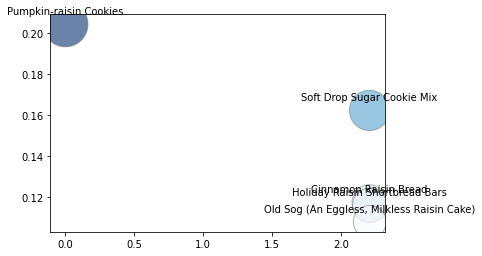

In [215]:
plt.scatter(df_to_plot['distance'], 
            df_to_plot['co2'], 
            s=df_to_plot['marker_size'], 
            c=df_to_plot['marker_size'], 
            cmap="Blues", 
            alpha=0.6, 
            edgecolors="grey", 
            linewidth=1, 
            label=df_to_plot['name'])

for x,y,z in zip(df_to_plot['distance'],df_to_plot['co2'],df_to_plot['name']):
    
    label = f"{z}"
    
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Nearest neighbors with c02 filtering

### Create Pipeline

def pipeline(n_components):
    pipe = Pipeline([
        ('dict_vectorizer', DictVectorizer(sparse=False)),
        ('pca', PCA(n_components=n_components))
    ])
    return pipe

pipe = pipeline(n_components)
pipe.fit(df.bow.tolist())

sample_test = 
df_filtered = df[df['co2']]
X2 = pipe.transform(df.bow.tolist())

# Export the data

## Export the data

### im2recipe dataframe

In [216]:
with open("../foodprint/cached_data/cached_im2recipe.pickle", "wb") as file:
    pickle.dump(df, file)

### Vectorized dataframe

In [197]:
with open("../foodprint/cached_data/cached_vectorized_data.pickle", "wb") as file:
    pickle.dump(pd.DataFrame(X, index=df.id), file)

### Informational dataframe

In [198]:
with open("../foodprint/cached_data/cached_informational_data.pickle", "wb") as file:
    pickle.dump(df, file)

## Export the pipeline

In [200]:
with open("../foodprint/cached_data/pipeline.pickle", "wb") as file:
    pickle.dump(pd.DataFrame(X, index=df.id), file)

## Exporte the model

In [201]:
# Export pipeline as pickle file
with open("../models/nneighbors_model.pkl", "wb") as file:
    pickle.dump(nn, file)

# Test All

### Id is provided

In [202]:
id = 'ffefad6dcc'

### load the data

In [204]:
# Load dataframe from pickle file
df_loaded = pickle.load(open("../foodprint/cached_data/cached_vectorized_data.pickle","rb"))

In [205]:
df_loaded.head()

0         1         2         3         4         5    \
id                                                                       
000095fc1d -0.661828 -0.500181  0.030801  0.066482 -0.188247 -0.037580   
00051d5b9d -0.051442 -0.167559  0.389512 -0.226786 -0.919618  0.588155   
00059b093b  0.171450  1.004136 -0.877200  0.452990 -0.118462  0.221703   
0005fc89f7 -0.871274 -0.090335  0.001575 -0.000387 -0.137020  0.445409   
0006ca31f4 -0.044486 -0.500178 -0.382693  0.368478 -0.350625 -0.015668   

                 6         7         8         9    ...       231       232  \
id                                                  ...                       
000095fc1d -0.189542 -0.145224 -0.163168 -0.042780  ...  0.058779  0.014860   
00051d5b9d -1.012921 -0.230566  0.107573 -0.187467  ... -0.004478 -0.000087   
00059b093b  0.860022  0.192291 -0.053758  0.424463  ... -0.028772  0.005467   
0005fc89f7  0.453396 -0.178838 -0.350404 -0.022537  ...  0.007570 -0.008989   
0006ca31f4  0.203325  0.208659  0.289014  0.194988  ... -0.005878 -0.014909   

                 233       234       235       236       237       238  \
id                                                                       
000095fc1d -0.228726 -0.139135  0.071398  0.119863 -0.055409  0.029328   
00051d5b9d -0.010160  0.000805  0.001328 -0.003747 -0.000531 -0.014558   
00059b093b -0.086486  0.045672  0.022658  0.097945  0.047040  0.028981   
0005fc89f7 -0.046798 -0.025451  0.030104 -0.014674  0.023511 -0.011475   
0006ca31f4  0.006681  0.007698 -0.002670 -0.001608 -0.000711 -0.000491   

                 239       240  
id                              
000095fc1d -0.001571 -0.027877  
00051d5b9d -0.004528  0.004895  
00059b093b  0.026219 -0.001995  
0005fc89f7 -0.085973  0.011167  
0006ca31f4 -0.001501 -0.001053  

[5 rows x 241 columns]

In [206]:
np.array(df_loaded).shape

(51235, 241)

### Get the recipe

In [207]:
recipe = np.array(df_loaded.loc[id]).reshape(-1,1).T

In [208]:
recipe.shape

(1, 241)

### Load the model

In [209]:
# Load model from pickle file
nn_loaded = pickle.load(open("../models/nneighbors_model.pkl","rb"))

### find the neighbors

In [210]:
n_neighbors = 5
neighbors = nn_loaded.kneighbors(X=recipe, n_neighbors=n_neighbors, return_distance=True)

In [211]:
neighbors

(array([[0.        , 2.20439266, 2.20704846, 2.20832353, 2.20858717]]),
 array([[51220, 28218, 40140,  2497, 36537]]))